## QBUS3850 Tutorial 12: Forecasting Value at Risk and Expected Shortfall

This exercise uses a progress-bar package called 'tqdm'. The usage is informative but not essential. `pip3 install tqdm`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
import scipy
from scipy import stats
from tqdm import tqdm

#Set print options to 4dp and suppress scientific notation
np.set_printoptions(precision=3, suppress=True) 

           Date         Open         High          Low        Close  \
4377 2017-04-07  5897.299805  5928.299805  5879.899902  5902.600098   
4378 2017-04-10  5902.600098  5948.899902  5902.600098  5948.899902   
4379 2017-04-11  5948.899902  5983.200195  5935.399902  5964.600098   
4380 2017-04-12  5964.600098  5978.899902  5950.399902  5968.899902   
4381 2017-04-13  5968.899902  5968.899902  5917.299805  5925.899902   

          Volume    Adj Close  
4377   940549200  5902.600098  
4378   765735000  5948.899902  
4379   788884600  5964.600098  
4380  1133380700  5968.899902  
4381  1024647300  5925.899902  


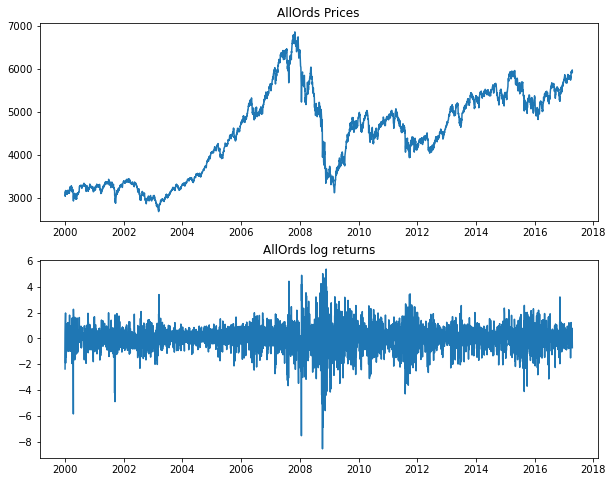

In [2]:
# Import All Ordinaries Index Data
AORD_data = pd.read_csv('AllORD0017.csv', parse_dates = ['Date'], dayfirst = True)
AOdates = AORD_data['Date']
AOp = AORD_data['Close']
print( AORD_data.tail() )

## Compute log-returns 
AOr = ( 100 * ( np.log( AOp ) - np.log( AOp.shift() ) ) )[1:]
assert( np.isnan( AOr ).sum() == 0 )

## Put dates, prices and returns all on the same basis.
#AOdates = AOdates[1:]
#AOp = AOp[1:]

#Plot All Ordinaries index values and returns
fig, axs = plt.subplots(2,1, figsize = (10,8))
axs[0].plot( AOdates, AOp )
axs[0].set_title( 'AllOrds Prices' )
axs[1].plot( AOdates[1:], AOr )
axs[1].set_title( 'AllOrds log returns' )
plt.show()


# Q1 - Forecasting 1 day VaR and ES

### Q1(a) Estimate GARCH(1,1) and GJR-GARCH(1,1) models, with Gaussian and Student-t errors, to the sample of log-returns leaving out the last 1000 days of returns. 

In [3]:
## In-sample and forecast sample
n = len(AOr)
nis = n-1000
AOris = AOr[:nis]
AOrf = AOr[nis:]

#Define and estimate models
Mdlg = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'gaussian')
EstMdlg = Mdlg.fit(disp='off')
Mdlgt = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
EstMdlgt = Mdlgt.fit(disp='off')
Mdlgj = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'gaussian')
EstMdlgj = Mdlgj.fit(disp='off')
Mdlgjt = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'studentst')
EstMdlgjt = Mdlgjt.fit(disp='off')


### Q1(b) Forecast 1-step-ahead VaR and ES, updating parameters every 20 days, for each of the last 1000 days of data, using the models in (a). 

### Q1(c) Include 1-step-ahead VaR and ES forecasts from a 100-day historical simulation. Include the RiskMetrics IGARCH model.


In [4]:
def VaR_n( p ):
    return stats.norm.ppf( p )
        
def ES_n( p ):
    return -stats.norm.pdf( stats.norm.ppf( p ) ) / p

def VaR_t( p, df ):
    return stats.t.ppf( p, df ) * np.sqrt( ( df - 2 ) / df )

def ES_t( p, df ):
    return -stats.t.pdf( stats.t.ppf( p, df ), df ) / p * ( df + stats.t.ppf( p, df )**2 ) / ( df - 1 ) * np.sqrt( ( df - 2 ) / df )


In [5]:
## 1-step-ahead VaR forecasts.
VaR1G = []
VaR5G = []
VaR1Gt = []
VaR5Gt = []
VaR1GJ = []
VaR5GJ = []
VaR1GJt = []
VaR5GJt = []
VaR1RM = []
VaR5RM = []
VaR1HS = []
VaR5HS = []

## 1-step-ahead ES forecasts.
ES1G = []
ES5G = []
ES1Gt = []
ES5Gt = []
ES1GJ = []
ES5GJ = []
ES1GJt = []
ES5GJt = []
ES1RM = []
ES5RM = []
ES1HS = []
ES5HS = []

## 1-step-ahead volatility forecasts 
SFAOg = []
SFAOgt = []
SFAOgj = []
SFAOgjt = []
SFAOrm = []

## Inferred degrees of freedom for t-GARCH models.
dfGt = []
dfGJt = []

for t in range( nis, n ):
    ## Fixed estimation window size
    AOris = AOr.values[ t - nis : t ]

    ## GARCH models
    Mdlg = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'gaussian')
    Mdlgt = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
    Mdlgj = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'gaussian')
    Mdlgjt = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'studentst')  
   
    if t % 20 == nis % 20: 
        ## Re-estimate models every 20 observations
        EstMdlg = Mdlg.fit(disp='off') 
        EstMdlgt = Mdlgt.fit(disp='off')
        EstMdlgj = Mdlgj.fit(disp='off') 
        EstMdlgjt = Mdlgjt.fit(disp='off')     
    else:  
        ## Use updated dataset but previously estimated model parameters.
        EstMdlg = Mdlg.fix( params = EstMdlg.params ) 
        EstMdlgt = Mdlgt.fix( params = EstMdlgt.params ) 
        EstMdlgj = Mdlgj.fix( params = EstMdlgj.params ) 
        EstMdlgjt = Mdlgjt.fix( params = EstMdlgjt.params ) 
        
    #1-step-ahead volatility forecasts 
    SFAOg.append( np.sqrt( EstMdlg.forecast( horizon = 1 ).variance.values[-1, 0] ) )
    SFAOgt.append( np.sqrt(EstMdlgt.forecast(horizon = 1).variance.values[-1, 0 ] ) )
    SFAOgj.append( np.sqrt(EstMdlgj.forecast(horizon = 1).variance.values[-1, 0 ] ) )
    SFAOgjt.append( np.sqrt(EstMdlgjt.forecast(horizon = 1).variance.values[-1, 0 ] ) )
    
    ## Inferred degrees of freedom
    dfGt.append( EstMdlgt.params['nu'] )
    dfGJt.append( EstMdlgjt.params['nu'] )
    
    #1-day ahead VaR forecasts for GARCH-type models
    VaR1G.append( EstMdlg.params['mu'] + VaR_n(0.01) * SFAOg[-1] )
    VaR5G.append( EstMdlg.params['mu'] + VaR_n(0.05) * SFAOg[-1] )
    VaR1Gt.append( EstMdlgt.params['mu'] + VaR_t(0.01, EstMdlgt.params['nu'] ) * SFAOgt[-1] )
    VaR5Gt.append( EstMdlgt.params['mu'] + VaR_t(0.05, EstMdlgt.params['nu'] ) * SFAOgt[-1] )
    VaR1GJ.append( EstMdlgj.params['mu'] + VaR_n(0.01) * SFAOgj[-1] )
    VaR5GJ.append( EstMdlgj.params['mu'] + VaR_n(0.05) * SFAOgj[-1] )
    VaR1GJt.append( EstMdlgjt.params['mu'] + VaR_t(0.01, EstMdlgjt.params['nu'] ) * SFAOgjt[-1] )
    VaR5GJt.append( EstMdlgjt.params['mu'] + VaR_t(0.05, EstMdlgjt.params['nu'] ) * SFAOgjt[-1] )

    #1-day ahead ES forecasts for GARCH-type models
    ES1G.append( EstMdlg.params['mu'] + ES_n(0.01) * SFAOg[-1] )
    ES5G.append( EstMdlg.params['mu'] + ES_n(0.05) * SFAOg[-1] )
    ES1Gt.append( EstMdlgt.params['mu'] + ES_t(0.01, EstMdlgt.params['nu'] ) * SFAOgt[-1] )
    ES5Gt.append( EstMdlgt.params['mu'] + ES_t(0.05, EstMdlgt.params['nu'] ) * SFAOgt[-1] )
    ES1GJ.append( EstMdlgj.params['mu'] + ES_n(0.01) * SFAOgj[-1] )
    ES5GJ.append( EstMdlgj.params['mu'] + ES_n(0.05) * SFAOgj[-1] )
    ES1GJt.append( EstMdlgjt.params['mu'] + ES_t(0.01, EstMdlgjt.params['nu'] ) * SFAOgjt[-1] )
    ES5GJt.append( EstMdlgjt.params['mu'] + ES_t(0.05, EstMdlgjt.params['nu'] ) * SFAOgjt[-1] )

    ## Riskmetrics (IGARCH)
    betaRM = 0.94    
    if t == nis:
        SFAOrm.append( np.std( AOris[-200:] ) )
    else:
        SFAOrm.append( np.sqrt( ( 1 - betaRM ) * AOris[-1]**2 + betaRM * SFAOrm[-1]**2 ) )

    VaR5RM.append( SFAOrm[-1] * VaR_n(0.05) )
    VaR1RM.append( SFAOrm[-1] * VaR_n(0.01) )
    ES5RM.append( SFAOrm[-1] * ES_n(0.05) )
    ES1RM.append( SFAOrm[-1] * ES_n(0.01) )

    ## Historical Simulation
    VaR5HS.append( np.percentile( AOris[-100:], 5, interpolation = 'midpoint') )
    VaR1HS.append( np.percentile( AOris[-100:], 1, interpolation = 'midpoint') )
    x100 = AOris[-100:]
    ES5HS.append( np.mean( x100[x100<=VaR5HS[-1]] ) )
    ES1HS.append( np.mean( x100[x100<=VaR1HS[-1]] ) )

    

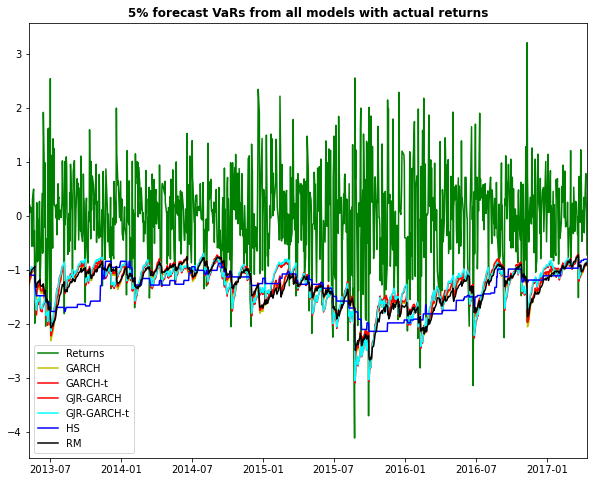

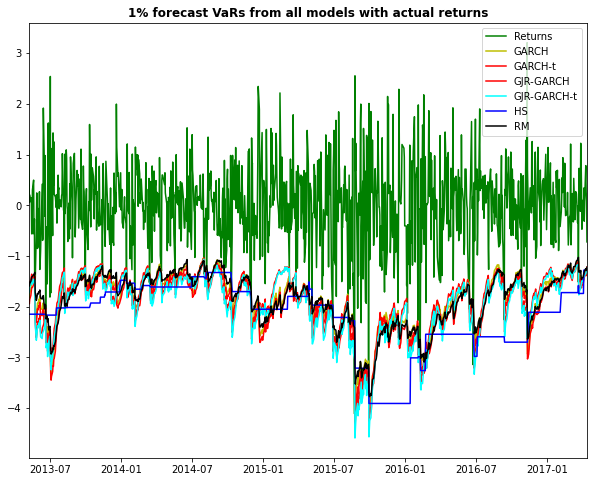

In [13]:
#Plot of 5% VaRs 
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(AOdates[-1000:], AOrf, c = 'g', label = 'Returns')
axs.plot(AOdates[-1000:], VaR5G, c = 'y', label = 'GARCH')
axs.plot(AOdates[-1000:], VaR5Gt, c = 'r', label = 'GARCH-t')
axs.plot(AOdates[-1000:], VaR5GJ, c = 'r', label = 'GJR-GARCH')
axs.plot(AOdates[-1000:], VaR5GJt, c = 'cyan', label = 'GJR-GARCH-t')
axs.plot(AOdates[-1000:], VaR5HS, c = 'b', label = 'HS')
axs.plot(AOdates[-1000:], VaR5RM, c = 'k', label = 'RM')
axs.set_xlim(AOdates[-1000:].min(), AOdates[-1000:].max())
axs.set_title('5% forecast VaRs from all models with actual returns', weight = 'bold')
axs.legend()
plt.show()

#Plot of 1% VaRs 
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(AOdates[-1000:], AOrf, c = 'g', label = 'Returns')
axs.plot(AOdates[-1000:], VaR1G, c = 'y', label = 'GARCH')
axs.plot(AOdates[-1000:], VaR1Gt, c = 'r', label = 'GARCH-t')
axs.plot(AOdates[-1000:], VaR1GJ, c = 'r', label = 'GJR-GARCH')
axs.plot(AOdates[-1000:], VaR1GJt, c = 'cyan', label = 'GJR-GARCH-t')
axs.plot(AOdates[-1000:], VaR1HS, c = 'b', label = 'HS')
axs.plot(AOdates[-1000:], VaR1RM, c = 'k', label = 'RM')
axs.set_xlim(AOdates[-1000:].min(), AOdates[-1000:].max())
axs.set_title('1% forecast VaRs from all models with actual returns', weight = 'bold')
axs.legend()
plt.show()


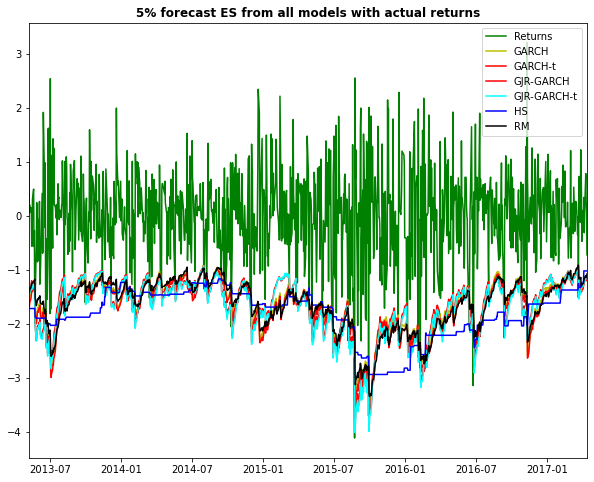

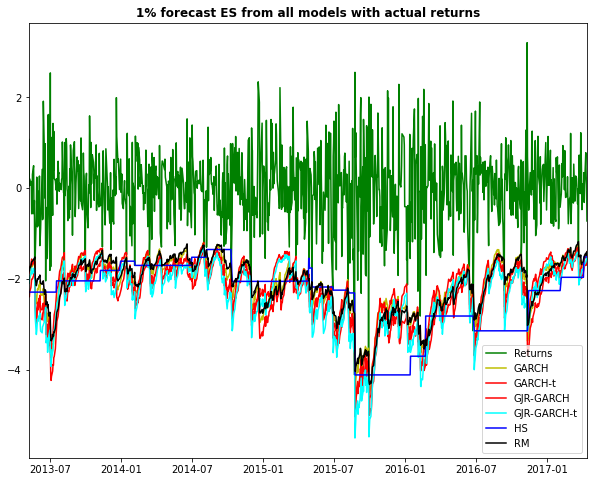

In [14]:
#Plot of 5% ESs 
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(AOdates[-1000:], AOrf, c = 'g', label = 'Returns')
axs.plot(AOdates[-1000:], ES5G, c = 'y', label = 'GARCH')
axs.plot(AOdates[-1000:], ES5Gt, c = 'r', label = 'GARCH-t')
axs.plot(AOdates[-1000:], ES5GJ, c = 'r', label = 'GJR-GARCH')
axs.plot(AOdates[-1000:], ES5GJt, c = 'cyan', label = 'GJR-GARCH-t')
axs.plot(AOdates[-1000:], ES5HS, c = 'b', label = 'HS')
axs.plot(AOdates[-1000:], ES5RM, c = 'k', label = 'RM')
axs.set_xlim(AOdates[-1000:].min(), AOdates[-1000:].max())
axs.set_title('5% forecast ES from all models with actual returns', weight = 'bold')
axs.legend()
plt.show()

#Plot of 1% ESs 
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(AOdates[-1000:], AOrf, c = 'g', label = 'Returns')
axs.plot(AOdates[-1000:], ES1G, c = 'y', label = 'GARCH')
axs.plot(AOdates[-1000:], ES1Gt, c = 'r', label = 'GARCH-t')
axs.plot(AOdates[-1000:], ES1GJ, c = 'r', label = 'GJR-GARCH')
axs.plot(AOdates[-1000:], ES1GJt, c = 'cyan', label = 'GJR-GARCH-t')
axs.plot(AOdates[-1000:], ES1HS, c = 'b', label = 'HS')
axs.plot(AOdates[-1000:], ES1RM, c = 'k', label = 'RM')
axs.set_xlim(AOdates[-1000:].min(), AOdates[-1000:].max())
axs.set_title('1% forecast ES from all models with actual returns', weight = 'bold')
axs.legend()
plt.show()

### Q1(d) Assess VaR violations for all models.

In [19]:
# 95% CI for violation rates
print([0.05 - 1.96 * np.sqrt(0.05 * 0.95 / 1000), 0.05 + 1.96 * np.sqrt(0.05 * 0.95 / 1000) ] )
print([0.01 - 1.96 * np.sqrt(0.01 * 0.99 / 1000), 0.01 + 1.96 * np.sqrt(0.01 * 0.99 / 1000) ] )

#accuracy of violation rates
def print_nviol( name, num, level ):
    print( "%s %i %f %f" % ( name.ljust(10), num, num/1000, num/1000/level ) )

print( "No of violations at 5%:" )
print_nviol( "G-N", ( AOrf<VaR5G ).sum(), 0.05 )
print_nviol( "GJ-N", ( AOrf<VaR5GJ ).sum(), 0.05 )
print_nviol( "G-t", ( AOrf<VaR5Gt ).sum(), 0.05 )
print_nviol( "GJ-t", ( AOrf<VaR5GJt ).sum(), 0.05 )
print_nviol( "RM", ( AOrf<VaR5RM ).sum(), 0.05 )
print_nviol( "HS100", ( AOrf<VaR5HS ).sum(), 0.05 )
print()

print( "No of violations at 1%:" )
print_nviol( "G-N", ( AOrf<VaR1G ).sum(), 0.01 )
print_nviol( "GJ-N", ( AOrf<VaR1GJ ).sum(), 0.01 )
print_nviol( "G-t", ( AOrf<VaR1Gt ).sum(), 0.01 )
print_nviol( "GJ-t", ( AOrf<VaR1GJt ).sum(), 0.01 )
print_nviol( "RM", ( AOrf<VaR1RM ).sum(), 0.01 )
print_nviol( "HS100", ( AOrf<VaR1HS ).sum(), 0.01 )
print()


[0.036491632222951584, 0.06350836777704842]
[0.003833003972759509, 0.01616699602724049]
No of violations at 5%:
G-N        59 0.059000 1.180000
GJ-N       59 0.059000 1.180000
G-t        63 0.063000 1.260000
GJ-t       61 0.061000 1.220000
RM         53 0.053000 1.060000
HS100      51 0.051000 1.020000

No of violations at 1%:
G-N        25 0.025000 2.500000
GJ-N       24 0.024000 2.400000
G-t        20 0.020000 2.000000
GJ-t       21 0.021000 2.100000
RM         28 0.028000 2.800000
HS100      10 0.010000 1.000000



The HS method is closest to the nominal violation rate at both 5% and 1%! Among GARCH-type models, RiskMetrics is closest to the 5% rate and GARCH-t to the 1% rate.

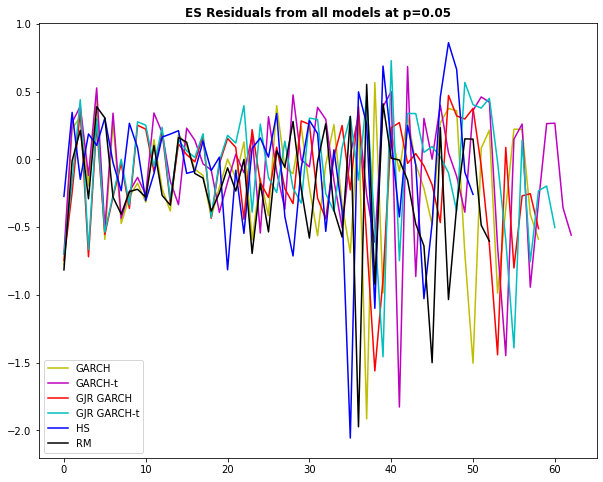

In [20]:
viol5G = ( AOrf<VaR5G )
viol5GJ = ( AOrf<VaR5GJ )
viol5Gt = ( AOrf<VaR5Gt )
viol5GJt = ( AOrf<VaR5GJt )
viol5RM = ( AOrf<VaR5RM )
viol5HS = ( AOrf<VaR5HS )

## p = 0.05 ES residuals (magnitudes of VaR violations)
err5G = ( AOrf - ES5G )[ viol5G ]
err5GJ = ( AOrf - ES5GJ )[ viol5GJ ]
err5Gt = ( AOrf - ES5Gt )[ viol5Gt]
err5GJt = ( AOrf - ES5GJt )[ viol5GJt ]
err5RM = ( AOrf - ES5RM )[ viol5RM ]
err5HS = ( AOrf - ES5HS )[ viol5HS]

#Plots of ES residuals for p=0.05
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(err5G.values, c = 'y', label = 'GARCH')
axs.plot(err5Gt.values, c = 'm', label = 'GARCH-t')
axs.plot(err5GJ.values, c = 'r', label = 'GJR GARCH')
axs.plot(err5GJt.values, c = 'c', label = 'GJR GARCH-t')
axs.plot(err5HS.values, c = 'b', label = 'HS')
axs.plot(err5RM.values, c = 'k', label = 'RM')
axs.set_title('ES Residuals from all models at p=0.05', weight = 'bold')
axs.legend()
plt.show()


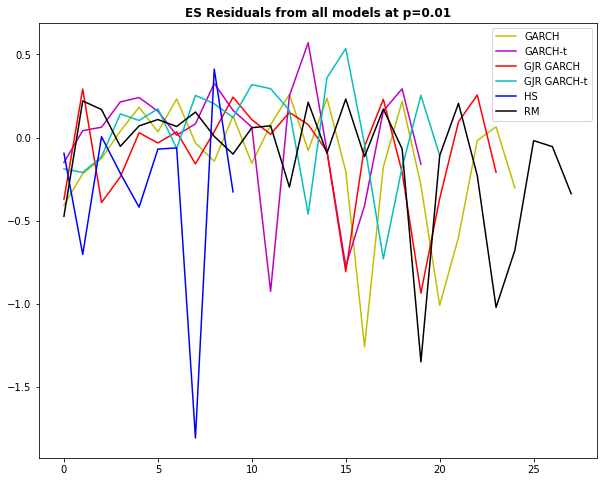

In [21]:
viol1G = ( AOrf<VaR1G )
viol1GJ = ( AOrf<VaR1GJ )
viol1Gt = ( AOrf<VaR1Gt )
viol1GJt = ( AOrf<VaR1GJt )
viol1RM = ( AOrf<VaR1RM )
viol1HS = ( AOrf<VaR1HS )

## p = 0.01 ES residuals (magnitudes of VaR violations)
err1G = ( AOrf - ES1G )[ viol1G ]
err1GJ = ( AOrf - ES1GJ )[ viol1GJ ]
err1Gt = ( AOrf - ES1Gt )[ viol1Gt]
err1GJt = ( AOrf - ES1GJt )[ viol1GJt ]
err1RM = ( AOrf - ES1RM )[ viol1RM ]
err1HS = ( AOrf - ES1HS )[ viol1HS]

#Plots of ES residuals for p=0.01
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(err1G.values, c = 'y', label = 'GARCH')
axs.plot(err1Gt.values, c = 'm', label = 'GARCH-t')
axs.plot(err1GJ.values, c = 'r', label = 'GJR GARCH')
axs.plot(err1GJt.values, c = 'c', label = 'GJR GARCH-t')
axs.plot(err1HS.values, c = 'b', label = 'HS')
axs.plot(err1RM.values, c = 'k', label = 'RM')
axs.set_title('ES Residuals from all models at p=0.01', weight = 'bold')
axs.legend()
plt.show()


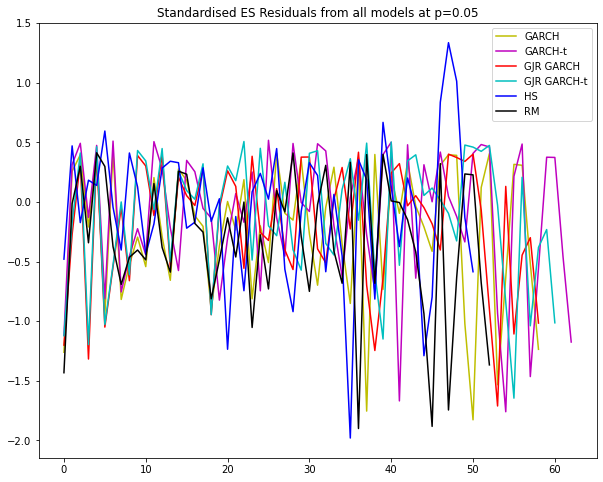

In [22]:
## p = 0.05 standardised ES residuals (scaled by volatility)
err5Gs = ( ( AOrf - ES5G ) / SFAOg )[viol5G]
err5GJs = ( ( AOrf - ES5GJ ) / SFAOgj )[viol5GJ]
err5Gts = ( ( AOrf - ES5Gt ) / SFAOgt )[viol5Gt]
err5GJts = ( ( AOrf - ES5GJt ) / SFAOgjt )[viol5GJt]
err5RMs = ( ( AOrf - ES5RM ) / SFAOrm )[viol5RM]
err5HSs = ( ( AOrf - ES5HS ) / SFAOrm )[viol5HS]

#Plots of ES residuals for p=0.05
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(err5Gs.values, c = 'y', label = 'GARCH')
axs.plot(err5Gts.values, c = 'm', label = 'GARCH-t')
axs.plot(err5GJs.values, c = 'r', label = 'GJR GARCH')
axs.plot(err5GJts.values, c = 'c', label = 'GJR GARCH-t')
axs.plot(err5HSs.values, c = 'b', label = 'HS')
axs.plot(err5RMs.values, c = 'k', label = 'RM')
axs.set_title('Standardised ES Residuals from all models at p=0.05' )
axs.legend()
plt.show()

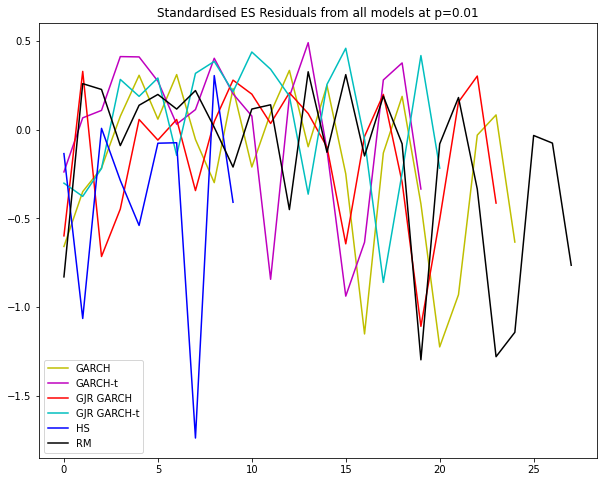

In [11]:
## p = 0.01 standardised ES residuals (scaled by volatility)
err1Gs = ( ( AOrf - ES1G ) / SFAOg )[viol1G]
err1GJs = ( ( AOrf - ES1GJ ) / SFAOgj )[viol1GJ]
err1Gts = ( ( AOrf - ES1Gt ) / SFAOgt )[viol1Gt]
err1GJts = ( ( AOrf - ES1GJt ) / SFAOgjt )[viol1GJt]
err1RMs = ( ( AOrf - ES1RM ) / SFAOrm )[viol1RM]
err1HSs = ( ( AOrf - ES1HS ) / SFAOrm )[viol1HS]

#Plots of ES residuals for p=0.01
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(err1Gs.values, c = 'y', label = 'GARCH')
axs.plot(err1Gts.values, c = 'm', label = 'GARCH-t')
axs.plot(err1GJs.values, c = 'r', label = 'GJR GARCH')
axs.plot(err1GJts.values, c = 'c', label = 'GJR GARCH-t')
axs.plot(err1HSs.values, c = 'b', label = 'HS')
axs.plot(err1RMs.values, c = 'k', label = 'RM')
axs.set_title('Standardised ES Residuals from all models at p=0.01' )
axs.legend()
plt.show()

In [23]:
#For p=0.05: sums, means and t-stats for ES residuals as well as means and t-stats for standardised ES residuals
print('\n', np.array([[np.sum(viol5G), np.sum(viol5GJ), np.sum(viol5RM), np.sum(viol5Gt), np.sum(viol5GJt), np.sum(viol5HS)], 
               [np.mean(err5G), np.mean(err5GJ), np.mean(err5RM), np.mean(err5Gt), np.mean(err5GJt), np.mean(err5HS)], 
               [np.mean(err5G)/(np.std(err5G)/np.sqrt(len(err5G))), np.mean(err5GJ)/(np.std(err5GJ)/np.sqrt(len(err5GJ))), np.mean(err5RM)/(np.std(err5RM)/np.sqrt(len(err5RM))), np.mean(err5Gt)/(np.std(err5Gt)/np.sqrt(len(err5Gt))), np.mean(err5GJt)/(np.std(err5GJt)/np.sqrt(len(err5GJt))), np.mean(err5HS)/(np.std(err5HS)/np.sqrt(len(err5HS)))], 
               [np.mean(err5Gs), np.mean(err5GJs), np.mean(err5RMs), np.mean(err5Gts), np.mean(err5GJts), np.mean(err5HSs)], 
               [np.mean(err5Gs)/(np.std(err5Gs)/np.sqrt(len(err5Gs))), np.mean(err5GJs)/(np.std(err5GJs)/np.sqrt(len(err5GJs))), np.mean(err5RMs)/(np.std(err5RMs)/np.sqrt(len(err5RMs))), np.mean(err5Gts)/(np.std(err5Gts)/np.sqrt(len(err5Gts))), np.mean(err5GJts)/(np.std(err5GJts)/np.sqrt(len(err5GJts))), np.mean(err5HSs)/(np.std(err5HSs)/np.sqrt(len(err5HSs)))]]))

#For p=0.01: sums, means and t-stats for ES residuals as well as means and t-stats for standardised ES residuals
print('\n', np.array([[np.sum(viol1G), np.sum(viol1GJ), np.sum(viol1RM), np.sum(viol1Gt), np.sum(viol1GJt), np.sum(viol1HS)], 
               [np.mean(err1G), np.mean(err1GJ), np.mean(err1RM), np.mean(err1Gt), np.mean(err1GJt), np.mean(err1HS)], 
               [np.mean(err1G)/(np.std(err1G)/np.sqrt(len(err1G))), np.mean(err1GJ)/(np.std(err1GJ)/np.sqrt(len(err1GJ))), np.mean(err1RM)/(np.std(err1RM)/np.sqrt(len(err1RM))), np.mean(err1Gt)/(np.std(err1Gt)/np.sqrt(len(err1Gt))), np.mean(err1GJt)/(np.std(err1GJt)/np.sqrt(len(err1GJt))), np.mean(err1HS)/(np.std(err1HS)/np.sqrt(len(err1HS)))], 
               [np.mean(err1Gs), np.mean(err1GJs), np.mean(err1RMs), np.mean(err1Gts), np.mean(err1GJts), np.mean(err1HSs)], 
               [np.mean(err1Gs)/(np.std(err1Gs)/np.sqrt(len(err1Gs))), np.mean(err1GJs)/(np.std(err1GJs)/np.sqrt(len(err1GJs))), np.mean(err1RMs)/(np.std(err1RMs)/np.sqrt(len(err1RMs))), np.mean(err1Gts)/(np.std(err1Gts)/np.sqrt(len(err1Gts))), np.mean(err1GJts)/(np.std(err1GJts)/np.sqrt(len(err1GJts))), np.mean(err1HSs)/(np.std(err1HSs)/np.sqrt(len(err1HSs)))]]))



 [[59.    59.    53.    63.    61.    51.   ]
 [-0.168 -0.144 -0.226 -0.075 -0.073 -0.067]
 [-2.766 -2.629 -3.569 -1.278 -1.33  -0.986]
 [-0.246 -0.2   -0.336 -0.124 -0.12  -0.072]
 [-3.293 -2.895 -4.199 -1.708 -1.742 -0.883]]

 [[25.    24.    28.    20.    21.    10.   ]
 [-0.141 -0.094 -0.115  0.008  0.04  -0.327]
 [-1.946 -1.518 -1.664  0.101  0.636 -1.83 ]
 [-0.189 -0.138 -0.161  0.017  0.048 -0.401]
 [-2.177 -1.802 -1.815  0.183  0.631 -2.237]]


Only the GARCH-t, GJR-t models have average ES residuals not significantly different from 0, at both 5% and 1% levels. The GARCH and HS100 models can be rejected for having average 1% ES residuals significantly different from 0. Both models have significantly negative residuals, meaning that their ES forecasts are not extreme enough.

In [24]:
#RMSE and MAD
print( 'G', 'GJ', 'RM', 'G-t', 'GJ-t', 'HS')
print( np.array([[np.sqrt(np.mean(err5G**2)), np.sqrt(np.mean(err5GJ**2)), np.sqrt(np.mean(err5RM**2)), np.sqrt(np.mean(err5Gt**2)), np.sqrt(np.mean(err5GJt**2)), np.sqrt(np.mean(err5HS**2))], 
          [np.sqrt(np.mean(err1G**2)), np.sqrt(np.mean(err1GJ**2)), np.sqrt(np.mean(err1RM**2)), np.sqrt(np.mean(err1Gt**2)), np.sqrt(np.mean(err1GJt**2)), np.sqrt(np.mean(err1HS**2))], 
          [np.mean(np.abs(err5G)), np.mean(np.abs(err5GJ)), np.mean(np.abs(err5RM)), np.mean(np.abs(err5Gt)), np.mean(np.abs(err5GJt)), np.mean(np.abs(err5HS))], 
          [np.mean(np.abs(err1G)), np.mean(np.abs(err1GJ)), np.mean(np.abs(err1RM)), np.mean(np.abs(err1Gt)), np.mean(np.abs(err1GJt)), np.mean(np.abs(err1HS))]]))

G GJ RM G-t GJ-t HS
[[0.496 0.444 0.513 0.475 0.436 0.492]
 [0.388 0.319 0.385 0.35  0.29  0.653]
 [0.367 0.329 0.366 0.361 0.335 0.34 ]
 [0.259 0.226 0.241 0.257 0.239 0.411]]


RMSE and MAD are suitable loss functions for forecasting ES accurately. Overall the GARCH-t model appears best under these criteria.

In [25]:
## For the Gaussian error models:
##  - the ES 5% occurs at the 0.0196 (or 1.96%) quantile,
##  - the ES 1% occurs at the 0.0038 (or 0.38%) quantile.
delaN5 = stats.norm.cdf( ES_n( 0.05 ) )
delaN1 = stats.norm.cdf( ES_n( 0.01 ) )

## For the Student-t error models, use the average degree of freedom from G-t and GJR-t 
## to determine what quantile the 5% and 1% ES should occur at, for that Student-t:
dfGt_avg = np.mean(dfGt)
dfGJt_avg = np.mean(dfGJt)
delaG5 = stats.t.cdf( ES_t( 0.05, dfGt_avg ), dfGt_avg )
delaG1 = stats.t.cdf( ES_t( 0.01, dfGt_avg ), dfGt_avg )
delaGJ5 = stats.t.cdf( ES_t( 0.05, dfGJt_avg ), dfGJt_avg )
delaGJ1 = stats.t.cdf( ES_t( 0.01, dfGJt_avg ), dfGJt_avg )

print( ' G      ', 'GJ     ', 'RM     ', 'G-t    ', 'GJ-t   ', 'HS     ' )
#Set print options to 4dp and suppress scientific notation
np.set_printoptions(precision=5, suppress=True) 
print( np.array( [delaN5, delaN5, delaN5, delaG5, delaGJ5, (delaG5+delaGJ5)/2] ) ) 
print( np.array( [delaN1, delaN1, delaN1, delaG1, delaGJ1, (delaG1+delaGJ1)/2] ) )

#dfGt = np.array(dfGt)
#dfGJt = np.array(dfGJt)
#delaG5t = stats.t.cdf( ES_t( 0.05, dfGt ), dfGt )
#delaG1t = stats.t.cdf( ES_t( 0.01, dfGt ), dfGt )
#delaGJ5t = stats.t.cdf( ES_t( 0.05, dfGJt ), dfGJt )
#delaGJ1t = stats.t.cdf( ES_t( 0.01, dfGJt ), dfGJt )

### Plot Changes in 1% ES quantile estimate
#fig, axs = plt.subplots(figsize = (10,8))
#axs.plot(AOdates[-1000:], delaG1t, c = 'b', label = 'GARCH-t')
#axs.plot(AOdates[-1000:], delaGJ1t, c = 'r', label = 'GJR-GARCH-t')
#axs.set_title('Changes in 1% ES quantile estimate for GARCH-t and GJR-t', weight = 'bold')
#plt.show()


 G       GJ      RM      G-t     GJ-t    HS     
[0.01957 0.01957 0.01957 0.02801 0.02662 0.02731]
[0.00385 0.00385 0.00385 0.00649 0.00607 0.00628]


The ES 5% and ES 1% occur at higher quantiles for the Student-t than for the Gaussian.

In [26]:
#Violations of ES forecasts
viol5VG = (AOrf<ES5G)
viol5VGJ = (AOrf<ES5GJ)
viol5VRM =(AOrf<ES5RM)
viol5VGt = (AOrf<ES5Gt)
viol5VGJt = (AOrf<ES5GJt)
viol5VHS = (AOrf<ES5HS)
viol1VG = (AOrf<ES1G)
viol1VGJ = (AOrf<ES1GJ)
viol1VRM = (AOrf<ES1RM)
viol1VGt = (AOrf<ES1Gt)
viol1VGJt = (AOrf<ES1GJt)
viol1VHS = (AOrf<ES1HS)

#Binomial confidence intervals for Gaussian and t models at 5% and 1% 
def binomial_ci( p ):
    return np.array( [ p - 1.96*np.sqrt( p*(1-p)/1000 ), p + 1.96*np.sqrt( p*(1-p)/1000 ) ] )

print('Gaussian 5% ', binomial_ci( delaN5 ) )
print('Student-t 5%', binomial_ci( delaG5 ) )
print('Gaussian 1% ', binomial_ci( delaN1 ) )
print('Student-t 1%', binomial_ci( delaG1 ) )

## Expect ES 5% violation rates for the Gaussian models in the range (0.0110, 0.0282) 
## with 95% confidence.
## Expect higher ES 5% violation rates for the Student-t models, in the range (0.0178, 0.0382)
## with 95% confidence.

## ES 5% violations 
print( [np.sum(viol5VG), np.sum(viol5VGJ), np.sum(viol5VRM), np.sum(viol5VGt), np.sum(viol5VGJt), np.sum(viol5VHS)] )

## ES 5% violation rates
print( [np.sum(viol5VG)/1000, np.sum(viol5VGJ)/1000, np.sum(viol5VRM)/1000, np.sum(viol5VGt)/1000, np.sum(viol5VGJt)/1000, np.sum(viol5VHS)/1000] )

## ES 1% violations 
print( [np.sum(viol1VG), np.sum(viol1VGJ), np.sum(viol1VRM), np.sum(viol1VGt), np.sum(viol1VGJt), np.sum(viol1VHS)] )

## ES 1% violation rates
print( [np.sum(viol1VG)/1000, np.sum(viol1VGJ)/1000, np.sum(viol1VRM)/1000, np.sum(viol1VGt)/1000, np.sum(viol1VGJt)/1000, np.sum(viol1VHS)/1000] )



Gaussian 5%  [0.01098 0.02816]
Student-t 5% [0.01779 0.03824]
Gaussian 1%  [0.00001 0.00768]
Student-t 1% [0.00151 0.01146]
[36, 34, 37, 33, 30, 25]
[0.036, 0.034, 0.037, 0.033, 0.03, 0.025]
[15, 12, 15, 6, 9, 8]
[0.015, 0.012, 0.015, 0.006, 0.009, 0.008]


The Gaussian models have too many violations, both at 5% and 1%, and can be rejected as under-estimating 5% ES risk levels. The Student-t models agree well with expected violation rates, both at 5% and 1%.

## Q1(e) Assess the models for ES forecast accuracy, independence and loss function values. 

In [30]:
#Define the 3 functions introduced in tutorial 11.
def indtest(hits):
    n = len(hits)

    r5 = hits[1:]
    r51 = hits[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)
  
    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

def dqtest(y,f,a,lag):
    n = len(y)
    hits = ((y<f)*1)*(1-a)
    hits = (hits)*1+(y>f)*(-a)
    q=2+lag
    
    if np.sum((y<f)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), f[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])
    
        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq

def qregloss(q,r,p):
    q = np.array( q )
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    qrgl = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return qrgl



In [31]:
#5% Independence tests
pG,lrG = indtest(viol5VG.values)
pGJ,lrGJ = indtest(viol5VGJ.values)
pRM,lrRM = indtest(viol5VRM.values)
pGt,lrGt = indtest(viol5VGt.values)
pGJt,lrGJt = indtest(viol5VGJt.values)
pHS1,lrHS1 = indtest(viol5VHS.values)
print('5% Independence tests', [round(x,4) for x in [pG, pGJ, pRM, pGt, pGJt, pHS1]])


dela5 = [delaN5, delaN5, delaN5, delaG5, delaGJ5, (delaG5+delaGJ5)/2]
dela1 = [delaN1, delaN1, delaN1, delaG1, delaGJ1, (delaG1+delaGJ1)/2]

#5% DQ tests
pdqG,dqG = dqtest(AOrf,ES5G,0.0196,4)
pdqGJ,dqGJ = dqtest(AOrf,ES5GJ,0.0196,4);
pdqRM,dqRM = dqtest(AOrf,ES5RM,0.0196,4);
pdqGt,dqGt = dqtest(AOrf,ES5Gt,delaG5,4);
pdqGJt,dqGJt = dqtest(AOrf,ES5GJt,delaGJ5,4);
pdqHS,dqHS =dqtest(AOrf,ES5HS,dela5[5],4);
print('5% DQ tests', [round(x, 4) for x in [pdqG, pdqGJ, pdqRM, pdqGt, pdqGJt, pdqHS]])

    #1% Independence tests
pG,lrG = indtest(viol1VG.values)
pGJ,lrGJ = indtest(viol1VGJ.values)
pRM,lrRM = indtest(viol1VRM.values)
pGt,lrGt = indtest(viol1VGt.values)
pGJt,lrGJt = indtest(viol1VGJt.values)
pHS1,lrHS1 = indtest(viol1VHS.values)
print('1% Independence tests', [round(x,4) for x in [pG, pGJ, pRM, pGt, pGJt, pHS1]])




#1% DQ tests
pdqG,dqG = dqtest(AOrf,ES1G,0.0038,4)
pdqGJ,dqGJ = dqtest(AOrf,ES1GJ,0.0038,4);
pdqRM,dqRM = dqtest(AOrf,ES1RM,0.0038,4);
pdqGt,dqGt = dqtest(AOrf,ES1Gt,delaG1,4);
pdqGJt,dqGJt = dqtest(AOrf,ES1GJt,delaGJ1,4);
pdqHS,dqHS =dqtest(AOrf,ES1HS,dela1[5],4);
print('1% DQ tests', [round(x, 4) for x in [pdqG, pdqGJ, pdqRM, pdqGt, pdqGJt, pdqHS]])

#5% Quantile Loss functions
loss5G = qregloss(ES5G,AOrf,0.0196)
loss5GJ = qregloss(ES5GJ,AOrf,0.0196)
loss5RM = qregloss(ES5RM,AOrf,0.0196)
loss5Gt = qregloss(ES5Gt,AOrf,delaG5);
loss5GJt = qregloss(ES5GJt,AOrf,delaGJ5)
loss5HS = qregloss(ES5HS,AOrf, (delaG5 + delaGJ5)/2 )
print('5% Loss Functions', [round(x, 4) for x in [loss5G, loss5GJ, loss5RM, loss5Gt, loss5GJt, loss5HS]])

#1% Quantile Loss functions
loss1G = qregloss(ES1G,AOrf ,0.0038)
loss1GJ = qregloss(ES1GJ,AOrf ,0.0038)
loss1RM = qregloss(ES1RM,AOrf ,0.0038)
loss1Gt = qregloss(ES1Gt,AOrf ,delaG1);
loss1GJt = qregloss(ES1GJt,AOrf ,delaGJ1)
loss1HS = qregloss(ES1HS,AOrf ,dela1[5])
print('1% Loss Functions', [round(x, 4) for x in [loss1G, loss1GJ, loss1RM, loss1Gt, loss1GJt, loss1HS]])

5% Independence tests [0.7783, 0.877, 0.5994, 0.9278, 0.9156, 0.6539]
5% DQ tests [0.0003, 0.0083, 0.0, 0.1532, 0.6317, 0.4627]
1% Independence tests [0.4989, 0.5891, 0.4989, 0.7877, 0.6858, 0.7193]
1% DQ tests [0.0, 0.001, 0.0, 0.9766, 0.4689, 0.6958]
5% Loss Functions [48.2539, 46.8473, 48.3047, 61.9773, 58.476, 60.2374]
1% Loss Functions [13.181, 12.1051, 13.1415, 18.1609, 16.5718, 18.8429]


The ES forecasts cannot be rejected for any model by the independence test. However, the Gaussian models are rejected by the more powerful DQ test at both 5% and 1%, while the Student-t and HS models are not rejected.

Unexpectedly, the quantile loss function favours the Gaussian models over the Student-t models.
I am not sure why this is.

# Question 2 VaR and ES forecasting, h > 1

### Consider the All Ordinaries Index data from Q1, now using the full sample.

### Q2(a) Using the models from Q1, forecast the VaR and ES at p = 0.05, 0.01, for the last 10-day period in the sample. Did the actual 10-day return fit in with the forecast 10-day return distributions, VaR and ES measures?

In [32]:
np.random.seed( 0x123123 )

#Q2(a) Forecast 10-day VaR and ES
    #Last 10 days of sample
nc = len(AOr)
ncis = nc-10
AOris = AOr[:ncis]

#Realised 10-day return over last 10 days
AO10 = np.sum(AOr[-10:])

#Define and estimate models
Mdlg = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'gaussian')
Mdlgt = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
Mdlgj = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'gaussian')
Mdlgjt = arch_model(y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'studentst')

EstMdlg = Mdlg.fit( disp='off' )
EstMdlgt = Mdlgt.fit( disp='off' )
EstMdlgj = Mdlgj.fit( disp='off' )
EstMdlgjt = Mdlgjt.fit( disp='off' )


## Simulate 10-day returns.
def step_10_g():
    a1G = EstMdlg.params['alpha[1]']
    a0G = EstMdlg.params['omega']
    b1G = EstMdlg.params['beta[1]']
    p0G = EstMdlg.params['mu']

    sret = np.zeros( ( nsim ) )
    sf = np.zeros( ( nsim ) )
    
    for h in range( 0, 10 ):
        if h == 0:
            sf.fill( np.sqrt( EstMdlg.forecast( horizon = 1 ).variance.values[-1] )[0] )
        else:
            sf = np.sqrt( a0G + a1G * a**2 + b1G * sf**2 ) 
          
        e = np.random.normal( size = nsim )
        a = sf * e 
        sret += p0G + a
    return sret

def step_10_gt():
    a1Gt = EstMdlgt.params['alpha[1]']
    a0Gt = EstMdlgt.params['omega']
    b1Gt = EstMdlgt.params['beta[1]']
    p0Gt = EstMdlgt.params['mu']
    dfGt = EstMdlgt.params['nu']

    sret = np.zeros( ( nsim ) )
    sf = np.zeros( ( nsim ) )

    for h in range( 0, 10 ):
        if h == 0:
            sf.fill( np.sqrt( EstMdlgt.forecast( horizon = 1 ).variance.values[-1] )[0] )
        else:
            sf = np.sqrt( a0Gt + a1Gt * a**2 + b1Gt * sf**2 ) 

        e = np.random.standard_t( df = dfGt, size = nsim ) * np.sqrt( ( dfGt - 2 ) / dfGt )
        a = sf * e 
        sret += p0Gt + a
    return sret
    
def step_10_gj():    
    a1GJ = EstMdlgj.params['alpha[1]']
    a0GJ = EstMdlgj.params['omega']
    b1GJ = EstMdlgj.params['beta[1]']
    p0GJ = EstMdlgj.params['mu']
    g1GJ = EstMdlgj.params['gamma[1]']
    
    sret = np.zeros( ( nsim ) )
    sf = np.zeros( ( nsim ) )

    for h in range( 0, 10 ):
        if h == 0:
            sf.fill( np.sqrt( EstMdlgj.forecast( horizon = 1 ).variance.values[-1] )[0] )
        else:
            sf = np.sqrt( a0GJ + ( a1GJ + g1GJ * ( a < 0 ) ) * a**2 + b1GJ * sf**2 ) 
           
        e = np.random.normal( size = nsim )
        a = sf * e 
        sret += p0GJ + a
    return sret
    
def step_10_gjt():    
    a1GJt = EstMdlgjt.params['alpha[1]']
    a0GJt = EstMdlgjt.params['omega']
    b1GJt = EstMdlgjt.params['beta[1]']
    p0GJt = EstMdlgjt.params['mu']
    g1GJt = EstMdlgjt.params['gamma[1]']
    dfGJt = EstMdlgjt.params['nu'] 

    sret = np.zeros( ( nsim ) )
    sf = np.zeros( ( nsim ) )
    
    for h in range( 0, 10 ):
        if h == 0:
            sf.fill( np.sqrt( EstMdlgt.forecast( horizon = 1 ).variance.values[-1] )[0] )
        else:
            sf = np.sqrt( a0GJt + ( a1GJt + g1GJt * ( a < 0 ) ) * a**2 + b1GJt * sf**2 ) 
          
        e = np.random.standard_t( df = dfGJt, size = nsim ) * np.sqrt( ( dfGJt - 2 ) / dfGJt )
        a = sf * e 
        sret += p0GJt + a
    return sret
 
import time
start_time = time.time()

nsim = 100000
    
sretg = step_10_g()
sretgt = step_10_gt()
sretgj = step_10_gj()    
sretgjt = step_10_gjt()

#Calculate VaRs at 5% and 1% level from nsim simulated 10-day returns
VaR5G10 = np.percentile(sretg, q = 5, interpolation = 'midpoint')
VaR1G10 = np.percentile(sretg, q = 1, interpolation = 'midpoint')
VaR5GJ10 = np.percentile(sretgj, q = 5, interpolation = 'midpoint')
VaR1GJ10 = np.percentile(sretgj, q = 1, interpolation = 'midpoint')
VaR5Gt10 = np.percentile(sretgt, q = 5, interpolation = 'midpoint')
VaR1Gt10 = np.percentile(sretgt, q = 1, interpolation = 'midpoint')
VaR5GJt10 = np.percentile(sretgjt, q = 5, interpolation = 'midpoint')
VaR1GJt10 = np.percentile(sretgjt, q = 1, interpolation = 'midpoint')
print('\nVaRs', [round(x,4) for x in [VaR5G10, VaR5GJ10, VaR5Gt10, VaR5GJt10, VaR1G10, VaR1GJ10, VaR1Gt10, VaR1GJt10]])

#Calculate ES at 5% and 1% level from nsim simulated 10-day returns
ES5G10 = np.mean(sretg[sretg<=VaR5G10])
ES1G10 = np.mean(sretg[sretg<=VaR1G10])
ES5GJ10 = np.mean(sretgj[sretgj<=VaR5GJ10])
ES1GJ10 = np.mean(sretgj[sretgj<=VaR1GJ10])
ES5Gt10 = np.mean(sretgt[sretgt<=VaR5Gt10])
ES1Gt10 = np.mean(sretgt[sretgt<=VaR1Gt10])
ES5GJt10 = np.mean(sretgjt[sretgjt<=VaR5GJt10])
ES1GJt10 = np.mean(sretgjt[sretgjt<=VaR1GJt10])
print('\nExpected Shortfall', [round(x,4) for x in [ES5G10, ES5GJ10, ES5Gt10, ES5GJt10, ES1G10, ES1GJ10, ES1Gt10, ES1GJt10]])

print("Elapsed: %fs." % (time.time() - start_time))



VaRs [-3.158, -3.3229, -2.9752, -3.3485, -4.925, -5.2814, -4.7919, -5.4999]

Expected Shortfall [-4.276, -4.5522, -4.1253, -4.7091, -6.0124, -6.5523, -5.9559, -6.9593]
Elapsed: 0.325679s.


### Q2(b) Plot the 10-day returns distributions from (a) and comment. Test the number of Monte Carlo samples needed to get reliable and repeatable 10-day VaR and ES forecasts. How much time does each run take at this MC sample size? Is that a reasonable or practical amount of time for this problem?

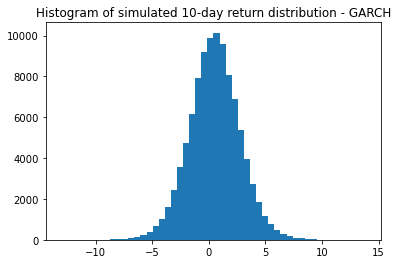

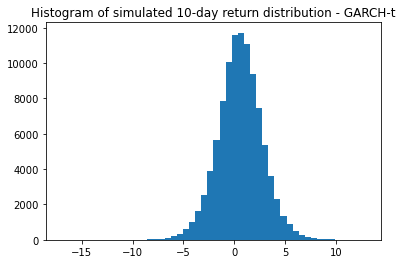

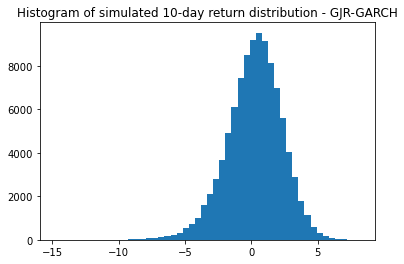

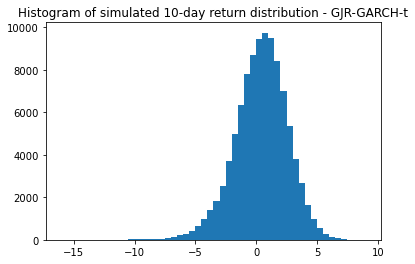

[[0.007490377841665783, 0.6205453695764698], [-0.43789060216058856, 0.7842456222249785], [-0.015371890499411116, 0.9262546941105296], [-0.44735363475250306, 1.0264708251665438]]

RiskMetrics VaRs [-4.6403, -3.281]

RiskMetrics Expected Shortfalls [-5.3163, -4.1145]


In [33]:
#Histograms of 10-day returns distributions
plt.hist(sretg, bins = 50)
plt.title('Histogram of simulated 10-day return distribution - GARCH')
plt.show()
plt.hist(sretgt, bins = 50)
plt.title('Histogram of simulated 10-day return distribution - GARCH-t')
plt.show()
plt.hist(sretgj, bins = 50)
plt.title('Histogram of simulated 10-day return distribution - GJR-GARCH')
plt.show()
plt.hist(sretgjt, bins = 50)
plt.title('Histogram of simulated 10-day return distribution - GJR-GARCH-t')
plt.show()

#JB tests for Gaussianity of 10-day returns distributions
test_stat, p_value = stats.jarque_bera(sretg) 
test_stat, p_value = stats.jarque_bera(sretgj)
test_stat, p_value = stats.jarque_bera(sretgt)
test_stat, p_value = stats.jarque_bera(sretgjt)

#Skewness and Kurtosis of 10-day returns distributions
print([[scipy.stats.skew(sretg), scipy.stats.kurtosis(sretg)], 
       [scipy.stats.skew(sretgj), scipy.stats.kurtosis(sretgj)], 
       [scipy.stats.skew(sretgt), scipy.stats.kurtosis(sretgt)], 
       [scipy.stats.skew(sretgjt), scipy.stats.kurtosis(sretgjt)]])

#RiskMetrics
sigRM = [np.std(AOr[:250])]
for t in range(1, ncis,1):
    sigRM.append(np.sqrt(0.06*AOr.iloc[t-1]**2+0.94*sigRM[t-1]**2))
sigRMf = sigRM[-1]
VaR5RM10 = np.sqrt(10)*sigRM[-1]*stats.norm.ppf(0.05);
VaR1RM10 = np.sqrt(10)*sigRM[-1]*stats.norm.ppf(0.01);
ES5RM10 = -stats.norm.pdf(stats.norm.ppf(0.05),0,1)/0.05*np.sqrt(10)*sigRMf
ES1RM10 = -stats.norm.pdf(stats.norm.ppf(0.01),0,1)/0.01*np.sqrt(10)*sigRMf


print('\nRiskMetrics VaRs', [round(x,4) for x in [VaR1RM10, VaR5RM10]])
print('\nRiskMetrics Expected Shortfalls', [round(x,4) for x in [ES1RM10, ES5RM10]])

The scale of the four distributions is quite comparable. Note that the GJR model induces a small amount of negative skewness in the 10-day return distribution. The skewness for the GJR model are both around -0.47. Also the excess kurtosis for the four distributions are all positive, indicating heavier tails than for a Gaussian random variable. JB tests strongly rejected Gaussianity for all distributions.

I used a Monte Carlo sample size of 100000 and it takes about 0.3s to run each time.

### Q2(c) Forecast the last 200 non-overlapping 10-day return distributions (using the last 2000 daily returns) and calculate the 200 10-day VaR and ES forecasts for p = 0.05, 0.01, using the models from Q1.

In [34]:
#repeat for last 200, 10 day returns.
nc = len(AOr)
n10 = 200
ncis = nc - 10 * n10
AOris = AOr[:ncis]

AO10 = np.zeros( ( n10 ) )

VaR5G10 = np.zeros( ( n10 ) )
VaR1G10 = np.zeros( ( n10 ) )
VaR5GJ10 = np.zeros( ( n10 ) )
VaR1GJ10 = np.zeros( ( n10 ) )
VaR5Gt10 = np.zeros( ( n10 ) )
VaR1Gt10 = np.zeros( ( n10 ) )
VaR5GJt10 = np.zeros( ( n10 ) )
VaR1GJt10 = np.zeros( ( n10 ) )
VaR5RM10 = np.zeros( ( n10 ) )
VaR1RM10 = np.zeros( ( n10 ) )

ES5G10 = np.zeros( ( n10 ) )
ES1G10 = np.zeros( ( n10 ) )
ES5GJ10 = np.zeros( ( n10 ) )
ES1GJ10 = np.zeros( ( n10 ) )
ES5Gt10 = np.zeros( ( n10 ) )
ES1Gt10 = np.zeros( ( n10 ) )
ES5GJt10 = np.zeros( ( n10 ) )
ES1GJt10 = np.zeros( ( n10 ) )
ES5RM10 = np.zeros( ( n10 ) )
ES1RM10 = np.zeros( ( n10 ) )

for t in tqdm( range( 0, n10 ) ): ## Optional: tqdm adds a progress bar to track the progress of the code execution
    AOris = AOr[:nc-2000+10*(t)]
    ncis = len(AOris)
    AO10[t] = np.sum(AOr[ncis-1:ncis+10])

    #parametric methods
    Mdlg = arch_model( y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'gaussian' )
    Mdlgt = arch_model( y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
    Mdlgj = arch_model( y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'gaussian' )
    Mdlgjt = arch_model( y = AOris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'studentst' )
    
    if t % 2 == 0:
        EstMdlg = Mdlg.fit( disp = 'off' )
        EstMdlgt = Mdlgt.fit( disp = 'off' )
        EstMdlgj = Mdlgj.fit( disp = 'off' )
        EstMdlgjt = Mdlgjt.fit( disp = 'off' )
    else:
        EstMdlg = Mdlg.fix( params = EstMdlg.params )
        EstMdlgt = Mdlgt.fix( params = EstMdlgt.params )
        EstMdlgj = Mdlgj.fix( params = EstMdlgj.params )
        EstMdlgjt = Mdlgjt.fix( params = EstMdlgjt.params )
        
    sretg = step_10_g()
    sretgj = step_10_gj()
    sretgt = step_10_gt()
    sretgjt = step_10_gjt()
        
    VaR5G10[t] = np.percentile(sretg, q = 5, interpolation = 'midpoint')
    VaR1G10[t] = np.percentile(sretg, q = 1, interpolation = 'midpoint')
    VaR5GJ10[t] = np.percentile(sretgj, q = 5, interpolation = 'midpoint')
    VaR1GJ10[t] = np.percentile(sretgj, q = 1, interpolation = 'midpoint')
    VaR5Gt10[t] = np.percentile(sretgt, q = 5, interpolation = 'midpoint')
    VaR1Gt10[t] = np.percentile(sretgt, q = 1, interpolation = 'midpoint')
    VaR5GJt10[t] = np.percentile(sretgjt, q = 5, interpolation = 'midpoint')
    VaR1GJt10[t] = np.percentile(sretgjt, q = 1, interpolation = 'midpoint')
    
    ES5G10[t] = np.mean(sretg[sretg<=VaR5G10[t-1]])
    ES1G10[t] = np.mean(sretg[sretg<=VaR1G10[t-1]])
    ES5GJ10[t] = np.mean(sretgj[sretgj<=VaR5GJ10[t-1]])
    ES1GJ10[t] = np.mean(sretgj[sretgj<=VaR1GJ10[t-1]])
    ES5Gt10[t] = np.mean(sretgt[sretgt<=VaR5Gt10[t-1]])
    ES1Gt10[t] = np.mean(sretgt[sretgt<=VaR1Gt10[t-1]])
    ES5GJt10[t] = np.mean(sretgjt[sretgjt<=VaR5GJt10[t-1]])
    ES1GJt10[t] = np.mean(sretgjt[sretgjt<=VaR1GJt10[t-1]])
    
    #RiskMetrics conditional distribution of a multi-period return is available in closed form (Tsay p.329).
    if t == 0:
        sigRM = np.std(AOris)
        
    for h in range(1, 10):
        sigRM = np.sqrt(0.06*AOr[ncis+h-11]**2+0.94*sigRM**2)

    VaR5RM10[t] = np.sqrt(10)*sigRM*stats.norm.ppf(0.05)
    VaR1RM10[t] = np.sqrt(10)*sigRM*stats.norm.ppf(0.01)
    ES5RM10[t] = -stats.norm.pdf(stats.norm.ppf(0.05),0,1)/0.05*np.sqrt(10)*sigRM
    ES1RM10[t] = -stats.norm.pdf(stats.norm.ppf(0.01),0,1)/0.01*np.sqrt(10)*sigRM


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:33<00:00,  2.15it/s]


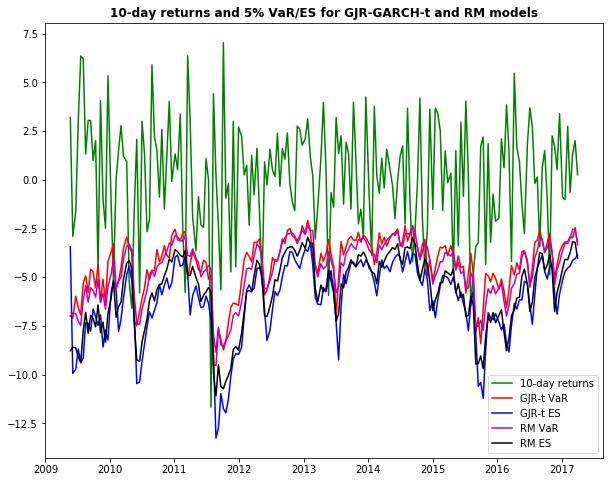

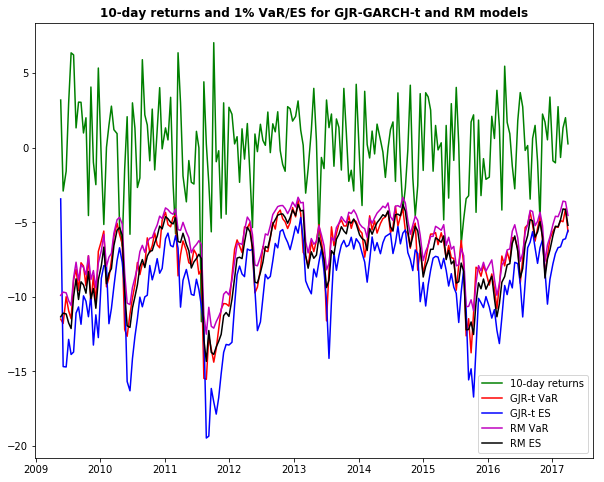

In [12]:
#Create dates for 10-day return plots
date_10 = AOdates[-2000:][::10]

#Plot 10-day returns with 5% VaR and ES from GJR-GARCH and Risk metrics
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(date_10, AO10, 'g', label = '10-day returns')
axs.plot(date_10, VaR5GJt10, 'r', label = 'GJR-t VaR')
axs.plot(date_10, ES5GJt10, 'b', label = 'GJR-t ES')
axs.plot(date_10, VaR5RM10, 'm', label = 'RM VaR')
axs.plot(date_10, ES5RM10, 'k', label = 'RM ES')
axs.set_title('10-day returns and 5% VaR/ES for GJR-GARCH-t and RM models', weight = 'bold')
axs.legend()

#Plot 10-day returns with 5% VaR and ES from GJR-GARCH and Risk metrics
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(date_10, AO10, 'g', label = '10-day returns')
axs.plot(date_10, VaR1GJt10, 'r', label = 'GJR-t VaR')
axs.plot(date_10, ES1GJt10, 'b', label = 'GJR-t ES')
axs.plot(date_10, VaR1RM10, 'm', label = 'RM VaR')
axs.plot(date_10, ES1RM10, 'k', label = 'RM ES')
axs.set_title('10-day returns and 1% VaR/ES for GJR-GARCH-t and RM models', weight = 'bold')
axs.legend()

### Q2(d) Which was best model at forecasting 10-day VaR and 10-day ES for each p? Was it the same as the best 1-day VaR or ES model? Why or why not?

In [16]:
## Violations
viol5G = AO10 < VaR5G10
err5G = AO10[AO10<VaR5G10] - ES5G10[AO10<VaR5G10]
viol1G = (AO10<VaR1G10)
err1G=AO10[AO10<VaR1G10]-ES1G10[AO10<VaR1G10]
viol5GJ =(AO10<VaR5GJ10)
err5GJ=AO10[AO10<VaR5GJ10]-ES5GJ10[AO10<VaR5GJ10]
viol1GJ =(AO10<VaR1GJ10)
err1GJ = AO10[AO10<VaR1GJ10]-ES1GJ10[AO10<VaR1GJ10]
viol5Gt = (AO10<VaR5Gt10)
err5Gt = AO10[AO10<VaR5Gt10]-ES5Gt10[AO10<VaR5Gt10]
viol1Gt = (AO10<VaR1Gt10)
err1Gt = AO10[AO10<VaR1Gt10]-ES1Gt10[AO10<VaR1Gt10]
viol5GJt = (AO10<VaR5GJt10)
err5GJt = AO10[AO10<VaR5GJt10]-ES5GJt10[AO10<VaR5GJt10]
viol1GJt = (AO10<VaR1GJt10)
err1GJt = AO10[AO10<VaR1GJt10]-ES1GJt10[AO10<VaR1GJt10]
viol5RM = (AO10<VaR5RM10)
err5RM = AO10[AO10<VaR5RM10]-ES5RM10[AO10<VaR5RM10]
viol1RM = (AO10<VaR1RM10)
err1RM = AO10[AO10<VaR1RM10]-ES1RM10[AO10<VaR1RM10]

#5% VaR assessment
vns = np.array([np.sum(viol5G), np.sum(viol5GJ), np.sum(viol5RM), np.sum(viol5Gt), np.sum(viol5GJt)])
print(vns)
print(vns/n10)
print(vns/n10/0.05)
print([0.05-1.96*np.sqrt(0.05*(1-0.05)/n10), 0.05+1.96*np.sqrt(0.05*(1-0.05)/n10)])

hits5G = (AO10<VaR5G10)
hits5Gt = (AO10<VaR5Gt10)
hits5GJ = (AO10<VaR5GJ10)
hits5GJt = (AO10<VaR5GJt10)
hits5RM = (AO10<VaR5RM10)

## Ind tests
pG,lrG = indtest(hits5G)
pGt,lrGt = indtest(hits5Gt)
pGJ,lrGJ = indtest(hits5GJ)
pGJt,lrGJt = indtest(hits5GJt)
pRM,lrRM = indtest(hits5RM)

print('\n5% VaR Hits', [pG, pGJ, pRM, pGt, pGJt])

## DQ tests
pdqG,dqG = dqtest(AO10,VaR5G10,0.05,4)
pdqGJ,dqGJ = dqtest(AO10,VaR5GJ10,0.05,4)
pdqRM,dqRM = dqtest(AO10,VaR5RM10,0.05,4)
pdqGt,dqGt = dqtest(AO10,VaR5Gt10,0.05,4)
pdqGJt,dqGJt = dqtest(AO10,VaR5GJt10,0.05,4)

print('\n5% VaR DQ test', [pdqG, pdqGJ, pdqRM, pdqGt, pdqGJt])

## loss functions
loss5G=qregloss(VaR5G10,AO10,0.05)
loss5Gt=qregloss(VaR5Gt10,AO10,0.05)
loss5GJ=qregloss(VaR5GJ10,AO10,0.05)
loss5GJt=qregloss(VaR5GJt10,AO10,0.05)
loss5RM=qregloss(VaR5RM10,AO10,0.05)

print('\n5% VaR Loss Functions', [loss5G, loss5GJ, loss5RM, loss5Gt, loss5GJt])

# 1% VaR assessment
vns = np.array([np.sum(viol1G), np.sum(viol1GJ), np.sum(viol1RM), np.sum(viol1Gt), np.sum(viol1GJt)])
print(vns)
print(vns/n10)
print(vns/n10/0.01)
print([0.01-1.96*np.sqrt(0.01*(1-0.01)/n10), 0.01+1.96*np.sqrt(0.01*(1-0.01)/n10)])

hits1G = (AO10<VaR1G10)
hits1Gt = (AO10<VaR1Gt10)
hits1GJ = (AO10<VaR1GJ10)
hits1GJt = (AO10<VaR1GJt10)
hits1RM = (AO10<VaR1RM10)

pG,lrG = indtest(hits1G)
pGt,lrGt = indtest(hits1Gt)
pGJ,lrGJ = indtest(hits1GJ)
pGJt,lrGJt = indtest(hits1GJt)
pRM,lrRM = indtest(hits1RM)
print('\n1% VaR Hits', [pG, pGJ, pRM, pGt, pGJt])

#DQ tests
pdqG,dqG = dqtest(AO10,VaR1G10,0.01,4)
pdqGJ,dqGJ = dqtest(AO10,VaR1GJ10,0.01,4)
pdqRM,dqRM = dqtest(AO10,VaR1RM10,0.01,4)
pdqGt,dqGt = dqtest(AO10,VaR1Gt10,0.01,4)
pdqGJt,dqGJt = dqtest(AO10,VaR1GJt10,0.01,4)
print('\n1% VaR DQ test', [pdqG, pdqGJ, pdqRM, pdqGt, pdqGJt])

#loss functions
loss1G=qregloss(VaR1G10,AO10,0.01)
loss1Gt=qregloss(VaR1Gt10,AO10,0.01)
loss1GJ=qregloss(VaR1GJ10,AO10,0.01)
loss1GJt=qregloss(VaR1GJt10,AO10,0.01)
loss1RM=qregloss(VaR1RM10,AO10,0.01)
print('\n1% VaR Loss Functions', [loss1G, loss1GJ, loss1RM, loss1Gt, loss1GJt])


[19 15 15 20 17]
[0.095 0.075 0.075 0.1   0.085]
[1.9 1.5 1.5 2.  1.7]
[0.01979437138545202, 0.08020562861454798]

5% VaR Hits [0.878903250563157, 0.8912981281813364, 0.4169524333228328, 0.4622452002660167, 0.6345470666036317]

5% VaR DQ test [0.0002661956363892992, 0.12762917550950836, 0.003996204301967121, 1.009266090290506e-05, 0.006371508666710102]

5% VaR Loss Functions [77.33707053117973, 72.90439325546443, 74.8846824673738, 78.4514288216872, 75.78519687258421]
[9 4 7 9 7]
[0.045 0.02  0.035 0.045 0.035]
[4.5 2.  3.5 4.5 3.5]
[-0.003789822333880883, 0.023789822333880883]

1% VaR Hits [0.35565227620163997, 0.6853038234954641, 0.22478449917792165, 0.35565227620163997, 0.4748308998565448]

1% VaR DQ test [1.714892428061887e-08, 0.7244766366516289, 1.023574510483627e-06, 1.5140841025385043e-08, 0.00039889162099226994]

1% VaR Loss Functions [24.361039362270834, 19.970282990366577, 24.1738561758211, 24.631256347343886, 20.9956353852819]


VaR assessment:

The 95% CI for the VRate is 0.0198,0.0802 which is 4 to 16 violations out of 200 data. As such, all models except GJR and RM are rejected for having too many violations. The GJR and RM models pass this test, but only just! All the models pass the independence test. All models except GJR-GARCH are rejected by the DQ test. Finally, GJR-GARCH is favoured by the loss function.

Residuals and t-tests for ES 5%:
[[-0.472 -0.401 -0.966 -0.402 -0.22 ]
 [-1.216 -1.232 -2.382 -1.064 -0.595]]
Residuals and t-tests for ES 1%:
[[ 0.358  0.981 -0.877  0.545  1.208]
 [ 0.888  2.028 -1.616  1.33   2.703]]
RMSE and MAD
[[1.755 1.322 1.843 1.737 1.538]
 [1.262 1.378 1.682 1.344 1.691]
 [1.332 0.901 1.195 1.338 1.069]
 [1.069 1.03  0.963 1.158 1.461]]


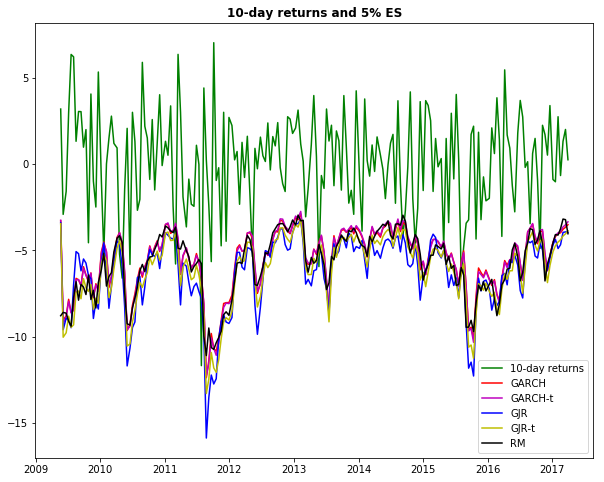

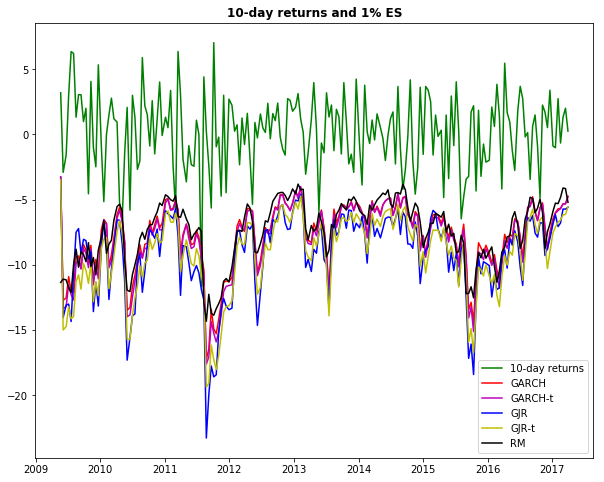

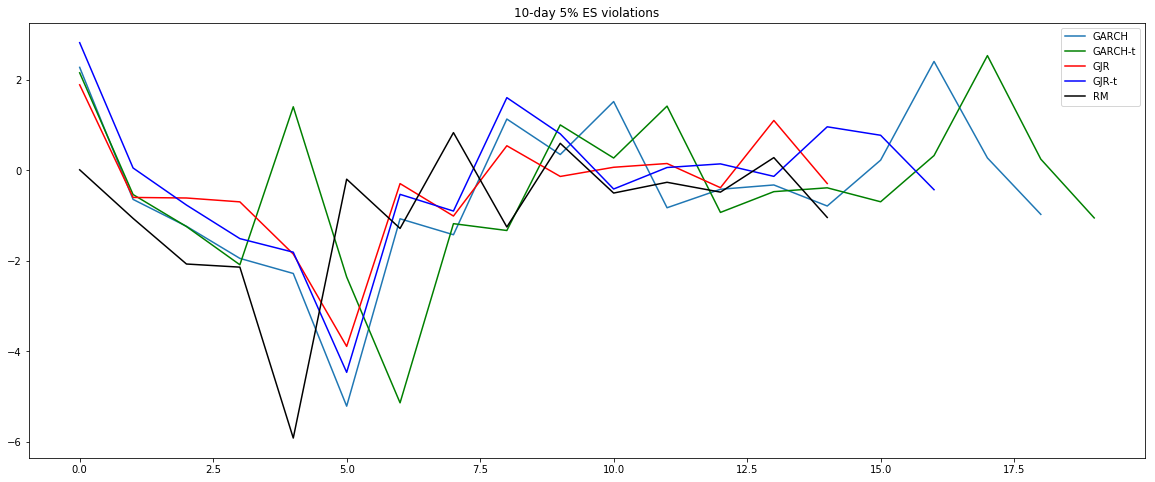

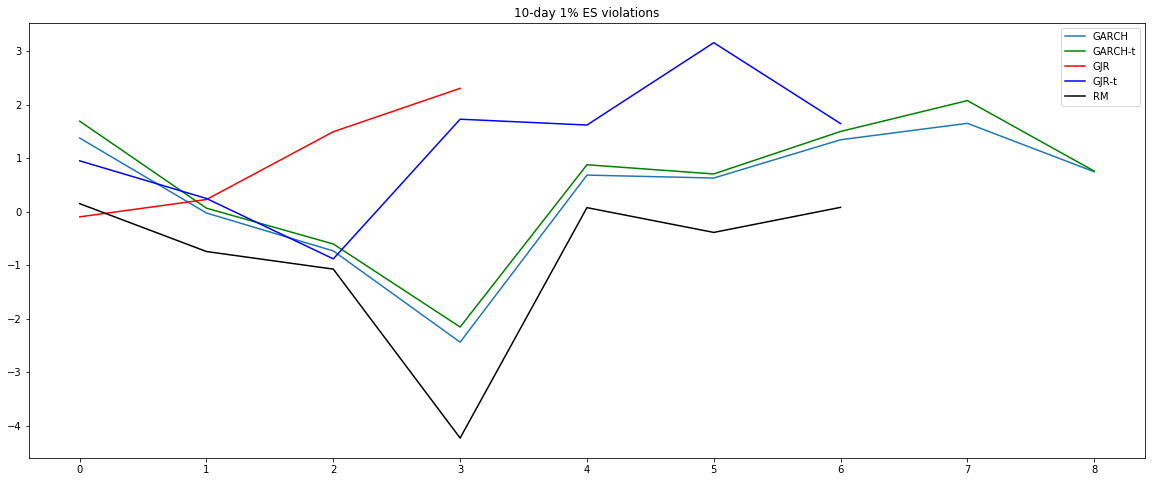

ES 5% violations:
[12 10 11 12  9]
[0.06  0.05  0.055 0.06  0.045]
ES 1% violations:
[3 1 4 2 1]
[0.015 0.005 0.02  0.01  0.005]

 5% ES Hits [0.7417045259003082, 0.5090651140010996, 0.6226131659120477, 0.7417045259003082, 0.4035439779151413]

 1% ES Hits [0.7617544400803311, 0.9198447093769825, 0.6853038234954641, 0.8401946437110719, 0.9198447093769825]


In [19]:

#ES assessment
#Plots of actual returns and ES for selected models
    #5%
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(date_10, AO10, 'g', label = '10-day returns')
axs.plot(date_10, ES5G10, 'r', label = 'GARCH')
axs.plot(date_10, ES5Gt10, 'm', label = 'GARCH-t')
axs.plot(date_10, ES5GJ10, 'b', label = 'GJR')
axs.plot(date_10, ES5GJt10, 'y', label = 'GJR-t')
axs.plot(date_10, ES5RM10, 'k', label = 'RM')
axs.set_title('10-day returns and 5% ES', weight = 'bold')
axs.legend()

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(date_10, AO10, 'g', label = '10-day returns')
axs.plot(date_10, ES1G10, 'r', label = 'GARCH')
axs.plot(date_10, ES1Gt10, 'm', label = 'GARCH-t')
axs.plot(date_10, ES1GJ10, 'b', label = 'GJR')
axs.plot(date_10, ES1GJt10, 'y', label = 'GJR-t')
axs.plot(date_10, ES1RM10, 'k', label = 'RM')
axs.set_title('10-day returns and 1% ES', weight = 'bold')
axs.legend()

#residuals and t-tests
print( "Residuals and t-tests for ES 5%:")
print( np.array([[np.mean(err5G), np.mean(err5GJ), np.mean(err5RM), np.mean(err5Gt), np.mean(err5GJt)], 
                [np.mean(err5G)/(np.std(err5G)/np.sqrt(len(err5G))), np.mean(err5GJ)/(np.std(err5GJ)/np.sqrt(len(err5GJ))), np.mean(err5RM)/(np.std(err5RM)/np.sqrt(len(err5RM))), np.mean(err5Gt)/(np.std(err5Gt)/np.sqrt(len(err5Gt))), np.mean(err5GJt)/(np.std(err5GJt)/np.sqrt(len(err5GJt)))]]))

print( "Residuals and t-tests for ES 1%:")
print( np.array([[np.mean(err1G), np.mean(err1GJ), np.mean(err1RM), np.mean(err1Gt), np.mean(err1GJt)], 
                [np.mean(err1G)/(np.std(err1G)/np.sqrt(len(err1G))), np.mean(err1GJ)/(np.std(err1GJ)/np.sqrt(len(err1GJ))), np.mean(err1RM)/(np.std(err1RM)/np.sqrt(len(err1RM))), np.mean(err1Gt)/(np.std(err1Gt)/np.sqrt(len(err1Gt))), np.mean(err1GJt)/(np.std(err1GJt)/np.sqrt(len(err1GJt)))]]))

#RMSE and MAD
print( "RMSE and MAD" )
print( np.array([[np.sqrt(np.mean(err5G**2)), np.sqrt(np.mean(err5GJ**2)), np.sqrt(np.mean(err5RM**2)), np.sqrt(np.mean(err5Gt**2)), np.sqrt(np.mean(err5GJt**2))], 
                [np.sqrt(np.mean(err1G**2)), np.sqrt(np.mean(err1GJ**2)), np.sqrt(np.mean(err1RM**2)), np.sqrt(np.mean(err1Gt**2)), np.sqrt(np.mean(err1GJt**2))],
                [np.mean(np.abs(err5G)), np.mean(np.abs(err5GJ)), np.mean(np.abs(err5RM)), np.mean(np.abs(err5Gt)), np.mean(np.abs(err5GJt))], 
                [np.mean(np.abs(err1G)), np.mean(np.abs(err1GJ)), np.mean(np.abs(err1RM)), np.mean(np.abs(err1Gt)), np.mean(np.abs(err1GJt))]]))


#Plots of violations for 10-day 5% ES
fig, axs = plt.subplots(figsize = (20,8))
axs.plot(err5G, label = 'GARCH')
axs.plot(err5Gt, c = 'g', label = 'GARCH-t')
axs.plot(err5GJ, c = 'r', label = 'GJR')
axs.plot(err5GJt, c = 'b', label = 'GJR-t')
axs.plot(err5RM, c = 'k', label = 'RM')
axs.set_title('10-day 5% ES violations')
axs.legend()
plt.show()

 #Plots of violations for 10-day 1% ES
fig, axs = plt.subplots(figsize = (20,8))
axs.plot(err1G, label = 'GARCH')
axs.plot(err1Gt, c = 'g', label = 'GARCH-t')
axs.plot(err1GJ, c = 'r', label = 'GJR')
axs.plot(err1GJt, c = 'b', label = 'GJR-t')
axs.plot(err1RM, c = 'k', label = 'RM')
axs.set_title('10-day 1% ES violations')
axs.legend()
plt.show()

#ES VRates
viol5VG = (AO10<ES5G10)
viol5VGt = (AO10<ES5Gt10)
viol5VGJ = (AO10<ES5GJ10)
viol5VGJt = (AO10<ES5GJt10)
viol5VRM =(AO10<ES5RM10)
viol1VG = (AO10<ES1G10)
viol1VGt = (AO10<ES1Gt10)
viol1VGJ = (AO10<ES1GJ10)
viol1VGJt = (AO10<ES1GJt10)
viol1VRM = (AO10<ES1RM10)

#Violation rates and tests
vns = np.array([np.sum(viol5VG), np.sum(viol5VGJ), np.sum(viol5VRM), np.sum(viol5VGt), np.sum(viol5VGJt)])
print( "ES 5% violations:")
print(vns)
print(vns/n10)
vns = np.array([np.sum(viol1VG), np.sum(viol1VGJ), np.sum(viol1VRM), np.sum(viol1VGt), np.sum(viol1VGJt)])
print( "ES 1% violations:")
print(vns)
print(vns/n10)

pG,lrG = indtest(viol5VG)
pGt,lrGt = indtest(viol5VGt)
pGJ,lrGJ = indtest(viol5VGJ)
pGJt,lrGJt = indtest(viol5VGJt)
pRM,lrRM = indtest(viol5VRM)
print('\n 5% ES Hits', [pG, pGJ, pRM, pGt, pGJt])

pG,lrG = indtest(viol1VG)
pGt,lrGt = indtest(viol1VGt)
pGJ,lrGJ = indtest(viol1VGJ)
pGJt,lrGJt = indtest(viol1VGJt)
pRM,lrRM = indtest(viol1VRM)
print('\n 1% ES Hits', [pG, pGJ, pRM, pGt, pGJt])

RM is rejected by the t-test. The residuals frome the ES 5% violations are plotted, and they look quite similar, though it is clear that the GJR models are smallest in magnitude on average.

Recall that, at the ES 5% level, we expect around 2% violations for the Gaussian models, and around 3% for the Student-t models. All the models have more than that many ES violations and all could be rejected on that count.

Likewise, at the ES 1% level, we expect around 0.4% violations for the Gaussian models, and around 0.6% for the Student-t models. On this basis, RM performs the worst with 4 violations, and GARCH-t the best.

